<a href="https://colab.research.google.com/github/vidhi-sys/GenAI_LangChain_and_RAG/blob/main/LangGraph_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#! pip install langgraph

[Langraph - Documentation](https://docs.langchain.com/oss/python/langgraph/overview)

In [2]:
from google.colab import userdata
import os
os.environ['OPENAI_API_KEY'] = userdata.get('openai_key')


In [3]:
# !pip install langchain_openai
from langchain_openai.chat_models import ChatOpenAI
llm=ChatOpenAI(temperature=0)

**STATE** - schema (data to be stored, data is basically a type dictionary )

In [4]:
from typing import TypedDict
class State (TypedDict):
  recipe:str
  ingredients:str
  prep_time:str # Changed to str, as LLM will return string
  eat_or_not:str
  dish: str # Added dish

In [5]:
from langgraph.graph import StateGraph
workflow=StateGraph(state_schema=State)

**NODES**:[Doc](https://docs.langchain.com/oss/python/langgraph/graph-api#nodes)

In [6]:
from langchain_core.prompts import ChatPromptTemplate

def recipe_of_dish(state:State)->State:
  print("Reviewing the recipe ....")
  prompt_template = ChatPromptTemplate.from_template("give me a small recipe of the dish {dish}")
  dish_name = state.get('dish', 'chicken curry') # Default for testing if not provided in initial state
  chain = prompt_template | llm
  response = chain.invoke({"dish": dish_name})
  state["recipe"] = response.content
  return state

workflow.add_node("recipe_of_dish", recipe_of_dish)

In [7]:
def ingredients(state:State)->State:
  print("Getting ingredients ...")
  recipe_text = state.get('recipe', 'a dish')
  prompt_template = f"What are the main ingredients for this recipe: {recipe_text}?"
  response = llm.invoke(prompt_template)
  state["ingredients"] = response.content
  return state
workflow.add_node("ingredients_ used ", ingredients)

In [8]:
def prep_time(state:State)->State:
  print("Getting preparation time ...")
  recipe_text = state.get('recipe', 'a dish')
  prompt_template = f"What is the approximate preparation time for this recipe: {recipe_text}? Respond only with a number of minutes."
  response = llm.invoke(prompt_template)
  state["prep_time"] = response.content
  return state
workflow.add_node("Preparation time", prep_time)

In [21]:
def eat_or_not(state: State)->State:
  print("Deciding whether to eat or not...")
  prep_time_val = state.get('prep_time', 'unknown time')
  recipe_val = state.get('recipe', 'unknown recipe')
  prompt_template = f"Based on preparation time: {prep_time_val}, and recipe: {recipe_val}, tell whether to eat or not eat. Respond concisely with 'Eat' or 'Do not eat'."
  response = llm.invoke(prompt_template)
  state["eat_or_not"] = response.content
  return state
workflow.add_node("eat_or_not", eat_or_not) # Added this line

**EDGES**

In [17]:
from langgraph.graph import START, END

# Set the entry point of the graph
workflow.set_entry_point("recipe_of_dish")

# Define unconditional edges
workflow.add_edge("recipe_of_dish", "ingredients_ used ")
workflow.add_edge("recipe_of_dish", "Preparation time")

# These edges will implicitly wait for both ingredients and prep_time to complete
workflow.add_edge("ingredients_ used ", "eat_or_not")
workflow.add_edge("Preparation time", "eat_or_not")

# Define conditional edges from 'eat_or_not' using route_app
workflow.add_conditional_edges(
    "eat_or_not",
    route_app,
    {
        "should_eat": END,
        "should_not_eat": END
    }
)

In [23]:
from langgraph.graph import END

def route_app(state:State)->str:
  print(f"Routing based on decision: {state.get('eat_or_not', 'No decision made')}")
  if "Eat" in state.get("eat_or_not", ""):
    return "should_eat"
  else:
    return "should_not_eat"

In [24]:
app = workflow.compile()

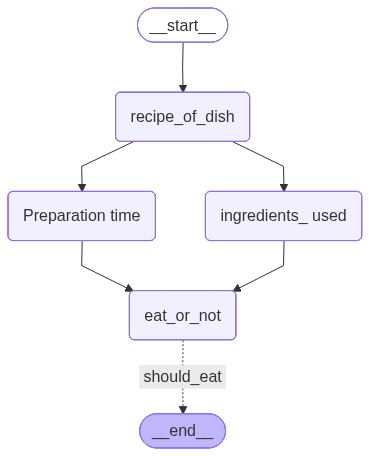

In [27]:
from IPython.display import Image,display
display(
    Image(
       app.get_graph().draw_mermaid_png()
        )
)

**TESTING**

In [29]:
def test(dish:str):
  results=app.invoke({"dish": dish})
  return(
      f"Dish: {dish}\n"
      f"Recipe: {results.get('recipe')}\n"
      f"Ingredients: {results.get('ingredients')}\n"
      f"Preparation Time: {results.get('prep_time')}\n"
  )

In [31]:
#test_dish="i want to eat yakhini pulav "
#print(test(test_dish))